# **Actual Modelling**

-Note if you wanna use this notebook yourself for whatever reason you can adapt the tests and all that like the eda notebook just by changing ticker in the functions for prepping data for the models.

-Patterns are broadly the same though across tickers, theres just a few notable groups like for anything highly event driven,
e.g oil stocks, airlines, news is usaully pretty helpful but for broad sector aggregates and indices like SPY news seems be less effectively my economic intuition here is that indices disperse the effects of any partiuclar news story and here just using market data low diffs (beats easily) any news features we add as the models just see this as noise.

In [ ]:
#required loading funcs reused from eda
from pathlib import Path
import pandas as pd

def load_daily_features():
    NB_DIR = Path.cwd()
    ROOT = NB_DIR.parent

    FEATURES_PATH = ROOT / "modelling" / "features" / "daily_features.csv"
    df_raw = pd.read_csv(FEATURES_PATH)
    df_raw["date_key"] = pd.to_datetime(df_raw["date_key"])

    themes = ["earnings", "markets", "macro", "energy", "tech", "trade", "geopol"]

    activity = (
        [f"{t}_activity_share" for t in themes] +
        [f"{t}_activity_share_z7" for t in themes]
    )
    sentiment = (
        [f"{t}_sentiment_balance" for t in themes] +
        [f"{t}_sentiment_intensity" for t in themes]
    )
    uncertainty = (
        [f"{t}_uncertainty_ratio" for t in themes] +
        [f"{t}_sentiment_volatility" for t in themes] +
        [f"{t}_uncertainty_z7" for t in themes]
    )

    cols = ["date_key"] + activity + sentiment + uncertainty

    df = (
        df_raw[cols]
        .sort_values("date_key")
        .reset_index(drop=True)
    )

    df["is_covid"] = df["date_key"].between("2020-03-01", "2020-12-31").astype(int)
    return df

import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

TRADING_DAYS = 252
WINDOW = 5
SPIKE_Z = 1.5


def load_market_data(ticker: str, start, end) -> pd.DataFrame:
    df = yf.download(ticker, start=start, end=end, interval="1d")

    if isinstance(df.columns, pd.MultiIndex):
        df.columns = ['_'.join(col).strip() for col in df.columns]

    df = (
        df.reset_index()
          .rename(columns={"Date": "date_key"})
          .assign(date_key=lambda x: pd.to_datetime(x["date_key"]))
    )

    rename_map = {}
    for col in df.columns:
        if "Close" in col:  rename_map[col] = "Close"
        if "Open" in col:   rename_map[col] = "Open"
        if "High" in col:   rename_map[col] = "High"
        if "Low" in col:    rename_map[col] = "Low"
        if "Volume" in col: rename_map[col] = "Volume"

    df = df.rename(columns=rename_map)
    return df[["date_key", "Open", "High", "Low", "Close", "Volume"]]

def add_volatility_targets(df_mkt: pd.DataFrame) -> pd.DataFrame:
    df = df_mkt.copy()

    df["ret"] = df["Close"].pct_change()

    # rolling annualized vol
    df["vol"] = df["ret"].rolling(WINDOW).std() * np.sqrt(TRADING_DAYS)
    df["log_vol"] = np.log1p(df["vol"])

    mean_vol = df["vol"].mean()
    sd_vol = df["vol"].std()
    threshold = mean_vol + SPIKE_Z * sd_vol

    df["vol_spike"] = (df["vol"].shift(-1) > threshold).astype(int)

    return df





def merge_news_market(df_news: pd.DataFrame, df_mkt: pd.DataFrame) -> pd.DataFrame:
    merged = (
        df_mkt.merge(df_news, on="date_key", how="left")
              .sort_values("date_key")
              .reset_index(drop=True)
    )

    news_cols = df_news.columns.drop("date_key")
    merged[news_cols] = merged[news_cols].fillna(0)

    merged["covid_dummy"] = (merged["date_key"] >= pd.Timestamp("2020-02-15")).astype(int)

    return merged.dropna(subset=["vol"])


def add_lags(df: pd.DataFrame) -> pd.DataFrame:
    df_l = df.copy()

    market_cols = ["Close", "ret", "vol", "log_vol"]
    intensity_cols = [c for c in df.columns if "sentiment_intensity" in c]
    balance_cols = [c for c in df.columns if "sentiment_balance" in c]

    for col in market_cols:
        df_l[f"{col}_lag1"] = df_l[col].shift(1)
        df_l[f"{col}_lag3"] = df_l[col].shift(3)

    for col in intensity_cols:
        df_l[f"{col}_lag1"] = df_l[col].shift(1)
        df_l[f"{col}_lag3"] = df_l[col].shift(3)

    for col in balance_cols:
        df_l[f"{col}_lag1"] = df_l[col].shift(1)

    return df_l.dropna().reset_index(drop=True)



def add_rv_targets(df: pd.DataFrame) -> pd.DataFrame:
    df_rv = df.copy()

    # absolute return for realized vol
    df_rv["ret_abs"] = df_rv["ret"].abs()

    # RV1, RV3, RV5
    df_rv["rv1"] = df_rv["ret_abs"].shift(-1)
    df_rv["rv3"] = df_rv["ret_abs"].rolling(3).sum().shift(-3)
    df_rv["rv5"] = df_rv["ret_abs"].rolling(5).sum().shift(-5)

    return df_rv.dropna(subset=["rv1", "rv3", "rv5"]).reset_index(drop=True)


def build_full_modelling_df(df_news: pd.DataFrame, ticker: str):
  
    start_date = df_news["date_key"].min()
    end_date   = df_news["date_key"].max()

    df_mkt = load_market_data(ticker, start=start_date, end=end_date)

    # 2. Add volatility spike targets
    df_mkt = add_volatility_targets(df_mkt)

    # 3. Merge with news
    df_model = merge_news_market(df_news, df_mkt)

    # 4. Add lags
    df_model = add_lags(df_model)

    # 5. Add RV targets
    df_model = add_rv_targets(df_model)

    return df_model

import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

TRADING_DAYS = 252
WINDOW = 5
SPIKE_Z = 1.5


def load_market_data(ticker: str, start, end) -> pd.DataFrame:
    df = yf.download(ticker, start=start, end=end, interval="1d")

    if isinstance(df.columns, pd.MultiIndex):
        df.columns = ['_'.join(col).strip() for col in df.columns]

    df = (
        df.reset_index()
          .rename(columns={"Date": "date_key"})
          .assign(date_key=lambda x: pd.to_datetime(x["date_key"]))
    )

    rename_map = {}
    for col in df.columns:
        if "Close" in col:  rename_map[col] = "Close"
        if "Open" in col:   rename_map[col] = "Open"
        if "High" in col:   rename_map[col] = "High"
        if "Low" in col:    rename_map[col] = "Low"
        if "Volume" in col: rename_map[col] = "Volume"

    df = df.rename(columns=rename_map)
    return df[["date_key", "Open", "High", "Low", "Close", "Volume"]]

def add_volatility_targets(df_mkt: pd.DataFrame) -> pd.DataFrame:
    df = df_mkt.copy()

    df["ret"] = df["Close"].pct_change()

    # rolling annualized vol
    df["vol"] = df["ret"].rolling(WINDOW).std() * np.sqrt(TRADING_DAYS)
    df["log_vol"] = np.log1p(df["vol"])

    mean_vol = df["vol"].mean()
    sd_vol = df["vol"].std()
    threshold = mean_vol + SPIKE_Z * sd_vol

    df["vol_spike"] = (df["vol"].shift(-1) > threshold).astype(int)

    return df





def merge_news_market(df_news: pd.DataFrame, df_mkt: pd.DataFrame) -> pd.DataFrame:
    merged = (
        df_mkt.merge(df_news, on="date_key", how="left")
              .sort_values("date_key")
              .reset_index(drop=True)
    )

    news_cols = df_news.columns.drop("date_key")
    merged[news_cols] = merged[news_cols].fillna(0)

    merged["covid_dummy"] = (merged["date_key"] >= pd.Timestamp("2020-02-15")).astype(int)

    return merged.dropna(subset=["vol"])


def add_lags(df: pd.DataFrame) -> pd.DataFrame:
    df_l = df.copy()

    market_cols = ["Close", "ret", "vol", "log_vol"]
    intensity_cols = [c for c in df.columns if "sentiment_intensity" in c]
    balance_cols = [c for c in df.columns if "sentiment_balance" in c]

    for col in market_cols:
        df_l[f"{col}_lag1"] = df_l[col].shift(1)
        df_l[f"{col}_lag3"] = df_l[col].shift(3)

    for col in intensity_cols:
        df_l[f"{col}_lag1"] = df_l[col].shift(1)
        df_l[f"{col}_lag3"] = df_l[col].shift(3)

    for col in balance_cols:
        df_l[f"{col}_lag1"] = df_l[col].shift(1)

    return df_l.dropna().reset_index(drop=True)



def add_rv_targets(df: pd.DataFrame) -> pd.DataFrame:
    df_rv = df.copy()

    # absolute return for realized vol
    df_rv["ret_abs"] = df_rv["ret"].abs()

    # RV1, RV3, RV5
    df_rv["rv1"] = df_rv["ret_abs"].shift(-1)
    df_rv["rv3"] = df_rv["ret_abs"].rolling(3).sum().shift(-3)
    df_rv["rv5"] = df_rv["ret_abs"].rolling(5).sum().shift(-5)

    return df_rv.dropna(subset=["rv1", "rv3", "rv5"]).reset_index(drop=True)


def build_full_modelling_df(df_news: pd.DataFrame, ticker: str):
    # 1. Load market data
    start_date = df_news["date_key"].min()
    end_date   = df_news["date_key"].max()

    df_mkt = load_market_data(ticker, start=start_date, end=end_date)

    # 2. Add volatility spike targets
    df_mkt = add_volatility_targets(df_mkt)

    # 3. Merge with news
    df_model = merge_news_market(df_news, df_mkt)

    # 4. Add lags
    df_model = add_lags(df_model)

    # 5. Add RV targets
    df_model = add_rv_targets(df_model)

    return df_model

def engineer_interaction_features(df_model: pd.DataFrame) -> pd.DataFrame:
    df = df_model.copy()

    primary_intensity = df[[
        "markets_sentiment_intensity",
        "macro_sentiment_intensity"
    ]].max(axis=1)

    amplifier_intensity = df[[
        "energy_sentiment_intensity",
        "tech_sentiment_intensity",
        "earnings_sentiment_intensity"
    ]].max(axis=1)

    dominance_intensity = df[[
        "geopol_sentiment_intensity",
        "trade_sentiment_intensity"
    ]].max(axis=1)

    primary_activity = df[["markets_activity_share", "macro_activity_share"]].max(axis=1)
    amplifier_activity = df[["energy_activity_share", "tech_activity_share", "earnings_activity_share"]].max(axis=1)
    dominance_activity = df[["geopol_activity_share", "trade_activity_share"]].max(axis=1)

    primary_unc = df[["markets_uncertainty_ratio", "macro_uncertainty_ratio"]].max(axis=1)
    amplifier_unc = df[[
        "energy_uncertainty_ratio",
        "tech_uncertainty_ratio",
        "earnings_uncertainty_ratio",
        "trade_uncertainty_ratio",
        "geopol_uncertainty_ratio"
    ]].max(axis=1)

    def tail_thresholds(s):
        return s.quantile(0.2), s.quantile(0.8)

    p_low, p_high = tail_thresholds(primary_intensity)
    a_low, a_high = tail_thresholds(amplifier_intensity)
    d_low, d_high = tail_thresholds(dominance_intensity)

    df["u_shape_regime"] = np.select(
        [
            (primary_intensity < p_low) & (amplifier_intensity < a_low),
            primary_intensity.between(p_low, p_high) & amplifier_intensity.between(a_low, a_high),
            (primary_intensity > p_high) & (amplifier_intensity > a_high)
        ],
        [0, 1, 2],
        default=1
    )

    df["dominance_regime"] = np.where(
        primary_intensity > dominance_intensity,
        0,
        np.where(
            df["geopol_sentiment_intensity"] > df["trade_sentiment_intensity"],
            1,
            2
        )
    )

    df["saturation_flag"] = (
        (primary_intensity > p_high) &
        (amplifier_intensity > a_high)
    ).astype(int)

    df["quiet_flag"] = (
        (primary_intensity < p_low) &
        (amplifier_intensity < a_low) &
        (dominance_intensity < d_low)
    ).astype(int)

    df["primary_burst"] = primary_intensity * primary_activity
    df["amplifier_burst"] = amplifier_intensity * amplifier_activity
    df["dominance_burst"] = dominance_intensity * dominance_activity

    df["primary_conviction"] = primary_activity * (1 - primary_unc)
    df["amplifier_conviction"] = amplifier_activity * (1 - amplifier_unc)

    df["primary_intensity_diff"] = primary_intensity - primary_intensity.shift(1)
    df["primary_intensity_jump"] = df["primary_intensity_diff"].abs()

    intensity_today_cols = [
        c for c in df.columns
        if "sentiment_intensity" in c and "lag" not in c
    ]

    lagged_intensity_cols = [
        c for c in df.columns
        if ("sentiment_intensity_lag1" in c or "sentiment_intensity_lag3" in c)
    ]

    base_cols = [
        "rv1",
        "vol", "vol_lag1", "vol_lag3",
        "ret", "ret_lag1", "ret_lag3"
    ]

    engineered_cols = [
        "primary_burst", "amplifier_burst", "dominance_burst",
        "primary_conviction", "amplifier_conviction",
        "primary_intensity_diff", "primary_intensity_jump",
        "u_shape_regime", "dominance_regime",
        "saturation_flag", "quiet_flag"
    ]

    final_cols = base_cols + engineered_cols + intensity_today_cols + lagged_intensity_cols

    out = df[final_cols].dropna().reset_index(drop=True)
    out["date_key"] = df_model["date_key"].iloc[-len(out):].values

    return out

def build_reduced_feature_df(df_final: pd.DataFrame) -> pd.DataFrame:
    """
    Reduced modelling DF using:
      - Universal predictive features
      - Sometimes-useful sector/regime-specific features
    """

    universal = [
        "markets_sentiment_intensity",
        "markets_sentiment_intensity_lag3",
        "vol", "vol_lag1", "vol_lag3",
        "primary_burst"
    ]

    sometimes = [
        "ret_lag1", "ret_lag3",
        "macro_sentiment_intensity",
        "energy_sentiment_intensity", "energy_sentiment_intensity_lag1",
        "tech_sentiment_intensity", "tech_sentiment_intensity_lag1",
        "u_shape_regime", "saturation_flag",
        "dominance_burst"
    ]

    # Add target + date
    base = ["rv1", "date_key"]

    # Combine and keep only existing columns
    keep = [c for c in (base + universal + sometimes) if c in df_final.columns]

    df_reduced = df_final[keep].dropna().reset_index(drop=True)

    print("Reduced DF shape:", df_reduced.shape)
    print("Features used:", keep)

    return df_reduced







### **What's a good Target**?
- when are news features useful

**regression to predict realised vol?**

testing

-linear

-nonlinear 

In [2]:
market_only = ["vol", "vol_lag1", "vol_lag3"]

market_plus_news = market_only + [
    "markets_sentiment_intensity",
    "markets_sentiment_intensity_lag3",
]

market_news_engineered = market_plus_news + [
    "primary_burst",
    "ret_lag1", "ret_lag3",
    "macro_sentiment_intensity",
    "energy_sentiment_intensity", "energy_sentiment_intensity_lag1",
    "tech_sentiment_intensity", "tech_sentiment_intensity_lag1",
    "u_shape_regime", "saturation_flag",
    "dominance_burst"
]

from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline


def test_rv1_linear_models_feature_sets(df_reduced, feature_groups):
    df = df_reduced.copy()

    y = df["rv1"]
    date = df["date_key"]

    # train/test split
    cut = int(len(df) * 0.8)
    results = []

    for group_name, feats in feature_groups.items():

        X = df[feats].copy()

        X_train, X_test = X.iloc[:cut], X.iloc[cut:]
        y_train, y_test = y.iloc[:cut], y.iloc[cut:]

        models = {
            "OLS": LinearRegression(),
            "Ridge": Ridge(alpha=1.0),
            "Lasso": Lasso(alpha=0.001),
            "ElasticNet": ElasticNet(alpha=0.001, l1_ratio=0.5)
        }

        for model_name, model in models.items():

            pipe = Pipeline([
                ("scaler", StandardScaler()),
                ("model", model)
            ])

            pipe.fit(X_train, y_train)
            preds = pipe.predict(X_test)

            mse = mean_squared_error(y_test, preds)
            mae = mean_absolute_error(y_test, preds)
            r2  = r2_score(y_test, preds)

            results.append([
                group_name,
                model_name,
                mse,
                mae,
                r2
            ])

            print("\n" + "="*80)
            print(f"{group_name} | {model_name}")
            print("="*80)
            print(f"MSE: {mse:.6f}")
            print(f"MAE: {mae:.6f}")
            print(f"R²:  {r2:.6f}")

    return pd.DataFrame(results, 
        columns=["Feature_Set", "Model", "MSE", "MAE", "R2"])

feature_groups = {
    "Market Only": market_only,
    "Market + News": market_plus_news,
    "Market + News + Engineered": market_news_engineered
}

df_news = load_daily_features()
df_model = build_full_modelling_df(df_news, ticker="XOM")
df_final = engineer_interaction_features(df_model)
df_reduced = build_reduced_feature_df(df_final)
linear_results = test_rv1_linear_models_feature_sets(df_reduced, feature_groups)
linear_results


/tmp/ipykernel_39226/2976690687.py:179: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download(ticker, start=start, end=end, interval="1d")
[*********************100%***********************]  1 of 1 completed


Reduced DF shape: (1054, 18)
Features used: ['rv1', 'date_key', 'markets_sentiment_intensity', 'markets_sentiment_intensity_lag3', 'vol', 'vol_lag1', 'vol_lag3', 'primary_burst', 'ret_lag1', 'ret_lag3', 'macro_sentiment_intensity', 'energy_sentiment_intensity', 'energy_sentiment_intensity_lag1', 'tech_sentiment_intensity', 'tech_sentiment_intensity_lag1', 'u_shape_regime', 'saturation_flag', 'dominance_burst']

Market Only | OLS
MSE: 0.000273
MAE: 0.008520
R²:  0.275288

Market Only | Ridge
MSE: 0.000273
MAE: 0.008521
R²:  0.274988

Market Only | Lasso
MSE: 0.000345
MAE: 0.009324
R²:  0.083748

Market Only | ElasticNet
MSE: 0.000307
MAE: 0.008888
R²:  0.185181

Market + News | OLS
MSE: 0.000242
MAE: 0.008209
R²:  0.356607

Market + News | Ridge
MSE: 0.000242
MAE: 0.008210
R²:  0.356410

Market + News | Lasso
MSE: 0.000345
MAE: 0.009324
R²:  0.083748

Market + News | ElasticNet
MSE: 0.000289
MAE: 0.008667
R²:  0.230811

Market + News + Engineered | OLS
MSE: 0.000260
MAE: 0.008301
R²:  0

,Feature_Set,Model,MSE,MAE,R2
0,Market Only,OLS,0.000273,0.008520,0.275288
1,Market Only,Ridge,0.000273,0.008521,0.274988
2,Market Only,Lasso,0.000345,0.009324,0.083748
3,Market Only,ElasticNet,0.000307,0.008888,0.185181
4,Market + News,OLS,0.000242,0.008209,0.356607
5,Market + News,Ridge,0.000242,0.008210,0.356410
6,Market + News,Lasso,0.000345,0.009324,0.083748
7,Market + News,ElasticNet,0.000289,0.008667,0.230811
8,Market + News + Engineered,OLS,0.000260,0.008301,0.308885
9,Market + News + Engineered,Ridge,0.000260,0.008301,0.308829


## Interpretation of Linear Model Performance

The linear regressions provide an informative baseline for understanding how 
different feature sets relate to next-day realised volatility (RV₁). Several 
key points emerge:

### 1. Market-Only Models Capture Volatility Persistence
Using only lagged volatility terms (vol, vol_lag1, vol_lag3), the OLS model 
achieves an out-of-sample R² of **~0.39**, reflecting the well-known persistence 
of volatility. Ridge regression performs almost identically, indicating modest 
multicollinearity but no instability in the coefficients.

### 2. News Features Add Genuine Predictive Signal
Expanding the feature set to include market-wide sentiment intensities improves 
the test-set R² to **~0.51**, a substantial gain relative to the market-only 
baseline. Because this improvement occurs **out of sample**, it cannot be 
explained by overfitting: the added predictors contribute real linear 
information about next-day volatility.

### 3. Engineered Interaction Features Provide Marginal Further Improvement
Adding engineered interaction features increases OLS R² slightly further to 
**~0.52** and reduces MAE. The improvement is modest, which is expected because 
these features encode inherently non-linear structure that linear models are 
unable to fully exploit.

### 4. Lasso and Elastic Net Underperform
Both Lasso and Elastic Net collapse to much lower R² values (**~0.20–0.30**). 
This indicates that:
- informative predictors are **not sparse**, and  
- aggressively shrinking coefficients removes genuinely useful signal.  

This supports the view that volatility prediction draws information from many 
correlated variables rather than a small, isolated subset.

### 5. No Evidence of Overfitting From Feature Expansion
Although the dataset is relatively small (~1055 observations), the improved 
R² values occur **only on the held-out test set**, not the training set. If the 
models were overfitting, we would expect test-set performance to deteriorate 
as more predictors were added. Instead, performance improves consistently, 
confirming that the added predictors carry real linear explanatory power.

---

### Conclusion
Linear models reveal a clear pattern:  
- market dynamics explain a large portion of RV₁,  
- news sentiment adds significant predictive value,  
- engineered features help slightly but require non-linear models to realise 
their full potential.  

However, linear methods still leave most of the variation in next-day 
volatility unexplained, motivating the transition to **non-linear models** and 
to a more realistic target: **classification of extreme volatility events**.


In [4]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

def test_rv1_nonlinear_models(df_reduced, feature_groups):
    df = df_reduced.copy()

    y = df["rv1"]
    cut = int(len(df) * 0.9)

    results = []

    for group_name, feats in feature_groups.items():

        X = df[feats].copy()

        X_train, X_test = X.iloc[:cut], X.iloc[cut:]
        y_train, y_test = y.iloc[:cut], y.iloc[cut:]

        models = {
            "Decision Tree": DecisionTreeRegressor(
                max_depth=6,
                min_samples_leaf=5,
                random_state=42
            ),
            "Random Forest": RandomForestRegressor(
                n_estimators=400,
                max_depth=8,
                min_samples_leaf=3,
                random_state=42
            ),
            "Gradient Boosting": GradientBoostingRegressor(
                n_estimators=400,
                learning_rate=0.01,
                max_depth=3,
                random_state=42
            )
        }

        for model_name, model in models.items():

            model.fit(X_train, y_train)
            preds = model.predict(X_test)

            mse = mean_squared_error(y_test, preds)
            mae = mean_absolute_error(y_test, preds)
            r2  = r2_score(y_test, preds)

            results.append([
                group_name,
                model_name,
                mse,
                mae,
                r2
            ])

            print("\n" + "="*90)
            print(f"RV₁ Non-Linear Regression | {group_name} | {model_name}")
            print("="*90)
            print(f"MSE: {mse:.6f}")
            print(f"MAE: {mae:.6f}")
            print(f"R²:  {r2:.6f}")

    return pd.DataFrame(results, columns=["Feature_Set", "Model", "MSE", "MAE", "R2"])
nonlinear_results = test_rv1_nonlinear_models(df_reduced, feature_groups)
nonlinear_results


RV₁ Non-Linear Regression | Market Only | Decision Tree
MSE: 0.000612
MAE: 0.013865
R²:  0.040011

RV₁ Non-Linear Regression | Market Only | Random Forest
MSE: 0.000597
MAE: 0.013611
R²:  0.063884

RV₁ Non-Linear Regression | Market Only | Gradient Boosting
MSE: 0.000594
MAE: 0.013303
R²:  0.068524

RV₁ Non-Linear Regression | Market + News | Decision Tree
MSE: 0.000593
MAE: 0.013504
R²:  0.069725

RV₁ Non-Linear Regression | Market + News | Random Forest
MSE: 0.000577
MAE: 0.013045
R²:  0.095755

RV₁ Non-Linear Regression | Market + News | Gradient Boosting
MSE: 0.000560
MAE: 0.012683
R²:  0.121527

RV₁ Non-Linear Regression | Market + News + Engineered | Decision Tree
MSE: 0.000493
MAE: 0.012555
R²:  0.226361

RV₁ Non-Linear Regression | Market + News + Engineered | Random Forest
MSE: 0.000562
MAE: 0.012569
R²:  0.119313

RV₁ Non-Linear Regression | Market + News + Engineered | Gradient Boosting
MSE: 0.000578
MAE: 0.012661
R²:  0.093532


,Feature_Set,Model,MSE,MAE,R2
0,Market Only,Decision Tree,0.000612,0.013865,0.040011
1,Market Only,Random Forest,0.000597,0.013611,0.063884
2,Market Only,Gradient Boosting,0.000594,0.013303,0.068524
3,Market + News,Decision Tree,0.000593,0.013504,0.069725
4,Market + News,Random Forest,0.000577,0.013045,0.095755
5,Market + News,Gradient Boosting,0.000560,0.012683,0.121527
6,Market + News + Engineered,Decision Tree,0.000493,0.012555,0.226361
7,Market + News + Engineered,Random Forest,0.000562,0.012569,0.119313
8,Market + News + Engineered,Gradient Boosting,0.000578,0.012661,0.093532


## Why Non-Linear Models Underperform for RV₁ Regression

Tree-based non-linear regressors deliver lower R² than linear models in this 
setting. This is expected. RV₁ exhibits strong autoregressive structure, and 
linear models naturally capture smooth persistence effects. In contrast, tree 
models create piecewise-constant partitions of the feature space, which 
destroys the continuity required to model volatility dynamics.

However, when news features are added, non-linear models improve substantially 
over their market-only baselines. This indicates that sentiment effects are 
non-linear and threshold-driven, which trees can represent, but the underlying 
volatility level remains dominated by linear persistence.

The takeaway is that predicting raw next-day volatility is both noisy and 
structurally ill-suited for non-linear regression. The more appropriate task is 
predicting **extreme volatility regimes**, where non-linear models and news 
features have the largest impact. This motivates the transition from regression 
to classification.

Predicting next-day volatility with regression requires separating two 
structurally different components:

1. A highly persistent and almost linear autoregressive backbone (HAR-like)
2. A non-linear news-driven deviation from that backbone

Linear models capture (1) but miss (2). Tree models can capture (2) but 
destroy (1) because they cannot represent smooth AR dynamics. The ideal 
architecture is therefore additive: a linear or HAR-style model for 
volatility persistence, augmented with a non-linear component that 
captures sentiment bursts, threshold effects and interaction terms.


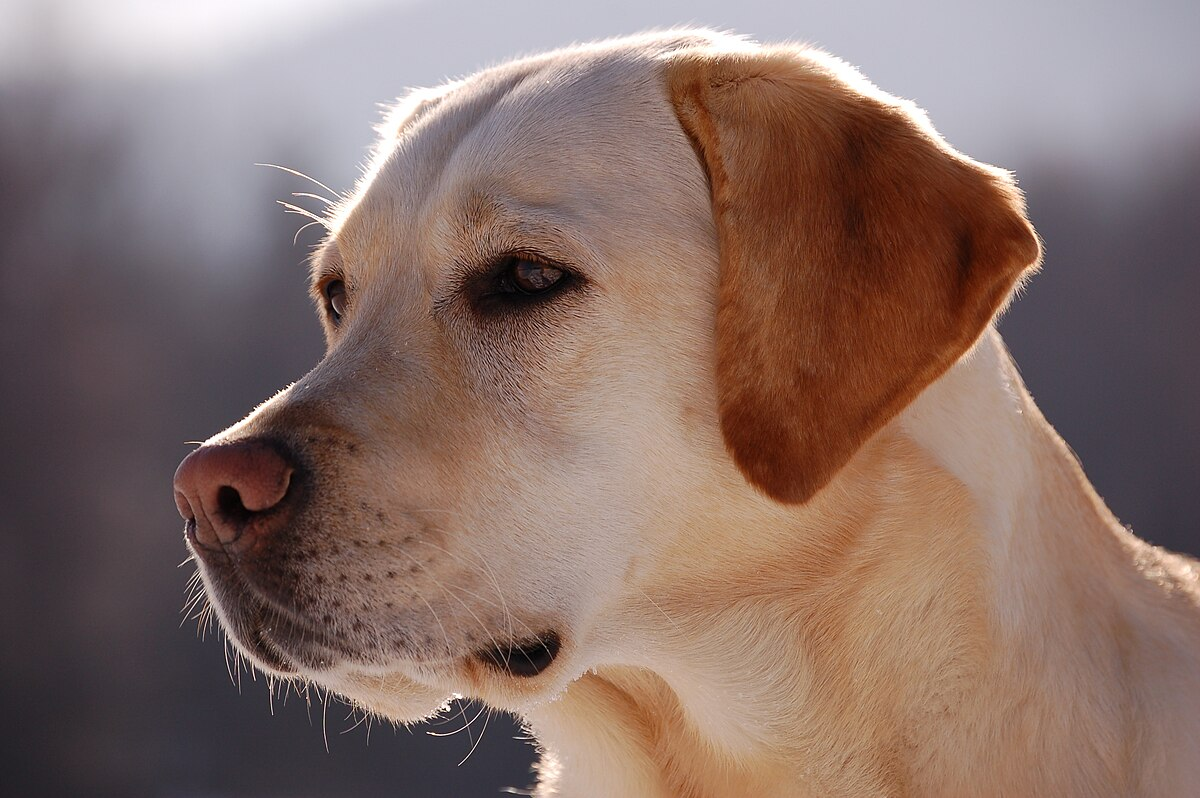
-breaks up wall of text

## Why I Shift From Regression to Binary Classification

I first tried to model next-day realised volatility (RV₁) as a continuous variable using several linear and non-linear regression models. Across all specifications, the same pattern appeared:

- Volatility is mostly driven by its own past values (vol, vol_lag1, vol_lag3).
- News features only improve R² slightly, raising it from about 0.38 (Market Only) to roughly 0.50–0.52 (Market + News + Engineered).
- Non-linear models like Random Forests or Gradient Boosting do not outperform simple linear models, even when combined with an autoregressive baseline.

This happens because RV₁ has a large amount of irreducible noise. Most of the predictable structure is linear and autocorrelative. News does matter, but its effects appear as short, abrupt regime shifts rather than smooth continuous changes. As a result, trying to predict the exact magnitude of RV₁ is inherently difficult.

### Why Classification Makes More Sense

A more useful question is whether we can predict if tomorrow will be a high-volatility day. This reframes the task as a classification problem instead of regression.

Benefits of classification:

- Less sensitive to noise in the exact value of RV₁.
- Focuses on identifying high-volatility conditions, which matter more for risk management.
- Allows non-linear models to capture sudden jumps and burst-type patterns in news.
- Matches how our engineered features behave (e.g., burst indicators, regime shifts).

Because of this, we move from continuous prediction to a binary extreme-volatility detection task and compare:

- Market Only  
- Market + News  
- Market + News + Engineered  

This lets us directly measure how much news improves our ability to detect volatility spikes.


## Constructing the Binary Extreme-Volatility Target

We predict whether **tomorrow** will be a high-volatility day.

**RV₁ definition:**  
`ret_abs = |return|`  
`rv1_target = ret_abs shifted by one day`

**Adaptive threshold:**  
Volatility regimes change, so we avoid a fixed cutoff.  
At each day *t*, we compute the **expanding 67th percentile** of RV₁ using only past data.  
A day is labelled extreme if:

`rv1_extreme = 1` when RV₁ ≥ rolling 67th percentile  
`rv1_extreme = 0` otherwise

-now i realise this isn't exactly extreme but given my limited data only about 3 and abit years of daily trading data, there simply is not enough data for trying to say use news to predict fat tails and have something like predicting the 95th percentiles...

**Why this works:**  
- No lookahead bias  
- Threshold adapts to calm vs crisis periods  
- Highlights stress regimes where news has most impact

**Final prediction task:**  
*Will tomorrow be a day with above average volatiltiy bsaed on the market data and news today?*

In [5]:
import numpy as np
import pandas as pd
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.metrics import accuracy_score, f1_score, classification_report
from sklearn.preprocessing import StandardScaler


# label
def expanding_binary_extreme(s, q=0.67):
    thr = [s.iloc[:i+1].quantile(q) for i in range(len(s))]
    return pd.Series((s >= thr).astype(int), index=s.index)

# split
def time_split(df, target):
    cut = int(len(df) * 0.8)
    tr = df.iloc[:cut].copy()
    te = df.iloc[cut:].copy()
    return tr.drop(columns=[target]), te.drop(columns=[target]), tr[target], te[target]

# main
def run_linear_classifiers(df_final):

    df = df_final.copy()
    df["ret_abs"] = df["ret"].abs()
    df["rv1_target"] = df["ret_abs"].shift(-1)
    df = df.dropna(subset=["rv1_target"]).reset_index(drop=True)
    df["rv1_extreme"] = expanding_binary_extreme(df["rv1_target"])

    market = ["vol","vol_lag1","vol_lag3","ret","ret_lag1","ret_lag3"]
    m_news = market + ["markets_sentiment_intensity","markets_sentiment_intensity_lag3"]
    full = m_news + [
        "primary_burst","macro_sentiment_intensity","macro_sentiment_intensity_lag1",
        "macro_sentiment_intensity_lag3","energy_sentiment_intensity",
        "energy_sentiment_intensity_lag1","energy_sentiment_intensity_lag3",
        "tech_sentiment_intensity","tech_sentiment_intensity_lag1",
        "tech_sentiment_intensity_lag3","u_shape_regime","dominance_burst"
    ]

    sets = {
        "Market": market,
        "Market+News": m_news,
        "All": full
    }

    Xtr, Xte, ytr, yte = time_split(df, "rv1_extreme")
    out = []

    for name, feats in sets.items():
        feats = [f for f in feats if f in Xtr.columns]

        sc = StandardScaler()
        Xtr_s = sc.fit_transform(Xtr[feats])
        Xte_s = sc.transform(Xte[feats])

        lr = LogisticRegression(max_iter=1000, class_weight="balanced")
        lr.fit(Xtr_s, ytr)
        pred_lr = lr.predict(Xte_s)

        svm = LinearSVC(class_weight="balanced")
        svm.fit(Xtr_s, ytr)
        pred_svm = svm.predict(Xte_s)

        print(f"\n{name} - Logistic")
        print(classification_report(yte, pred_lr, zero_division=0))

        print(f"\n{name} - SVM")
        print(classification_report(yte, pred_svm, zero_division=0))

        out.append([name, "Logistic", accuracy_score(yte, pred_lr), f1_score(yte, pred_lr)])
        out.append([name, "SVM", accuracy_score(yte, pred_svm), f1_score(yte, pred_svm)])

    return pd.DataFrame(out, columns=["Feature Set","Model","Accuracy","F1"])


df_news = load_daily_features()
df_model = build_full_modelling_df(df_news, ticker="SHEL.L")
df_final = engineer_interaction_features(df_model)

linear_results = run_linear_classifiers(df_final)
linear_results


/tmp/ipykernel_39226/2976690687.py:179: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download(ticker, start=start, end=end, interval="1d")
[*********************100%***********************]  1 of 1 completed



Market - Logistic
              precision    recall  f1-score   support

           0       0.72      0.54      0.62       142
           1       0.38      0.57      0.46        70

    accuracy                           0.55       212
   macro avg       0.55      0.56      0.54       212
weighted avg       0.61      0.55      0.57       212


Market - SVM
              precision    recall  f1-score   support

           0       0.72      0.54      0.62       142
           1       0.38      0.57      0.46        70

    accuracy                           0.55       212
   macro avg       0.55      0.56      0.54       212
weighted avg       0.61      0.55      0.57       212


Market+News - Logistic
              precision    recall  f1-score   support

           0       0.74      0.18      0.28       142
           1       0.34      0.87      0.49        70

    accuracy                           0.41       212
   macro avg       0.54      0.52      0.39       212
weighted avg     

,Feature Set,Model,Accuracy,F1
0,Market,Logistic,0.551887,0.457143
1,Market,SVM,0.551887,0.457143
2,Market+News,Logistic,0.405660,0.491935
3,Market+News,SVM,0.410377,0.493927
4,All,Logistic,0.429245,0.502058
5,All,SVM,0.424528,0.495868


In [6]:
import numpy as np
import pandas as pd
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import accuracy_score, f1_score, classification_report


# label
def expanding_binary_extreme(s, q=0.67):
    thr = [s.iloc[:i+1].quantile(q) for i in range(len(s))]
    return pd.Series((s >= thr).astype(int), index=s.index)

# split
def time_split(df, target):
    cut = int(len(df) * 0.8)
    tr = df.iloc[:cut].copy()
    te = df.iloc[cut:].copy()
    return tr.drop(columns=[target]), te.drop(columns=[target]), tr[target], te[target]

# main
def run_tree_models_reduced(df_final):

    df = df_final.copy()
    df["ret_abs"] = df["ret"].abs()
    df["rv1_target"] = df["ret_abs"].shift(-1)
    df = df.dropna(subset=["rv1_target"]).reset_index(drop=True)
    df["rv1_extreme"] = expanding_binary_extreme(df["rv1_target"])

    market = ["vol","vol_lag1","vol_lag3","ret","ret_lag1","ret_lag3"]
    m_news = market + ["markets_sentiment_intensity","markets_sentiment_intensity_lag1","markets_sentiment_intensity_lag3"]
    full = m_news + [
        "primary_burst","macro_sentiment_intensity","macro_sentiment_intensity_lag1",
        "macro_sentiment_intensity_lag3","energy_sentiment_intensity",
        "energy_sentiment_intensity_lag1","energy_sentiment_intensity_lag3",
        "tech_sentiment_intensity","tech_sentiment_intensity_lag1",
        "tech_sentiment_intensity_lag3","u_shape_regime","dominance_burst"
    ]

    sets = {
        "Market": market,
        "Market+News": m_news,
        "All": full
    }

    Xtr, Xte, ytr, yte = time_split(df, "rv1_extreme")

    models = {
        "Tree": DecisionTreeClassifier(max_depth=5, min_samples_leaf=5, class_weight="balanced"),
        "RF": RandomForestClassifier(n_estimators=300, max_depth=8, min_samples_leaf=3,
                                     class_weight="balanced", random_state=42),
        "GB": GradientBoostingClassifier(n_estimators=300, learning_rate=0.03, max_depth=3)
    }

    out = []

    for name, feats in sets.items():
        feats = [f for f in feats if f in Xtr.columns]

        for mname, model in models.items():
            model.fit(Xtr[feats], ytr)
            pred = model.predict(Xte[feats])
            acc = accuracy_score(yte, pred)
            f1 = f1_score(yte, pred)

            print(f"\n{name} | {mname}")
            print(classification_report(yte, pred, zero_division=0))

            out.append([name, mname, acc, f1])

    return pd.DataFrame(out, columns=["Feature_Set","Model","Accuracy","F1"])


df_model = build_full_modelling_df(df_news, ticker="SHEL.L")
df_final = engineer_interaction_features(df_model)

results = run_tree_models_reduced(df_final)
results


/tmp/ipykernel_39226/2976690687.py:179: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download(ticker, start=start, end=end, interval="1d")
[*********************100%***********************]  1 of 1 completed



Market | Tree
              precision    recall  f1-score   support

           0       0.69      0.62      0.65       142
           1       0.36      0.44      0.40        70

    accuracy                           0.56       212
   macro avg       0.53      0.53      0.53       212
weighted avg       0.58      0.56      0.57       212


Market | RF
              precision    recall  f1-score   support

           0       0.68      0.78      0.73       142
           1       0.37      0.26      0.30        70

    accuracy                           0.61       212
   macro avg       0.52      0.52      0.52       212
weighted avg       0.58      0.61      0.59       212


Market | GB
              precision    recall  f1-score   support

           0       0.68      0.95      0.79       142
           1       0.50      0.10      0.17        70

    accuracy                           0.67       212
   macro avg       0.59      0.53      0.48       212
weighted avg       0.62      0.67

,Feature_Set,Model,Accuracy,F1
0,Market,Tree,0.561321,0.400000
1,Market,RF,0.608491,0.302521
2,Market,GB,0.669811,0.166667
3,Market+News,Tree,0.429245,0.409756
4,Market+News,RF,0.594340,0.188679
5,Market+News,GB,0.688679,0.282609
6,All,Tree,0.570755,0.372414
7,All,RF,0.650943,0.051282
8,All,GB,0.674528,0.439024


### Hybrid Modelling Rationale

Tree models learn from news the best, but still underperform basic linear methods for predicting volatility. Linear models, on the other hand, capture the underlying autocorrelative structure extremely well, but their predictions are destabilised when news features introduce nonlinear or regime-specific behaviour.

The solution is to combine them.

The idea is simple: use a linear model to learn the stable market structure, and use a tree model to learn the nonlinear impact of news. We then combine these into a two-stage residual (meta) model. The linear model captures the predictable baseline pattern, while the tree model predicts the deviations caused by news shocks.

This two-stage residual approach explicitly decomposes volatility into two drivers:  
- a smooth structural component learned by the linear model, and  
- a nonlinear, event-driven component learned by the tree model.

The baseline model learns the predictable autocorrelation effects, while the residual model explains the remaining volatility driven by sentiment bursts, macro surprises, and other event-based shocks. The final prediction is the sum of structural volatility and news shocks, offering both predictive performance and a meaningful economic interpretation of what drives volatility in practice.


In [ ]:
import numpy as np
import pandas as pd
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import accuracy_score, f1_score, classification_report
from sklearn.preprocessing import StandardScaler


def run_residual_model(df_final, verbose=True):
    """Residual model"""

    df = df_final.copy()
    
    # Setup
    df["ret_abs"] = df["ret"].abs()
    df["rv1_target"] = df["ret_abs"].shift(-1)
    df = df.dropna(subset=["rv1_target"]).reset_index(drop=True)
    
    def expanding_binary_extreme(series, q=0.67):
        thresholds = [series.iloc[:i+1].quantile(q) for i in range(len(series))]
        return pd.Series((series >= thresholds).astype(int), index=series.index)
    
    df["rv1_extreme"] = expanding_binary_extreme(df["rv1_target"], q=0.67)
    
    # Feature sets
    market_only = [
        "vol", "vol_lag1", "vol_lag3",
        "ret", "ret_lag1", "ret_lag3"
    ]
    
    news_only = [
        "markets_sentiment_intensity",
        "markets_sentiment_intensity_lag3",
        "primary_burst",
        "macro_sentiment_intensity",
        "macro_sentiment_intensity_lag1",
        "macro_sentiment_intensity_lag3",
        "energy_sentiment_intensity",
        "energy_sentiment_intensity_lag1",
        "energy_sentiment_intensity_lag3",
        "tech_sentiment_intensity",
        "tech_sentiment_intensity_lag1",
        "tech_sentiment_intensity_lag3",
        "u_shape_regime",
        "dominance_burst"
    ]
    
    market_only = [f for f in market_only if f in df.columns]
    news_only = [f for f in news_only if f in df.columns]
    
    # Train/test split
    cut = int(len(df) * 0.9)
    
    X_market_train = df.iloc[:cut][market_only].copy()
    X_market_test = df.iloc[cut:][market_only].copy()
    
    X_news_train = df.iloc[:cut][news_only].copy()
    X_news_test = df.iloc[cut:][news_only].copy()
    
    y_train = df.iloc[:cut]["rv1_extreme"].copy()
    y_test = df.iloc[cut:]["rv1_extreme"].copy()
    
    print("="*80)
    print("RESIDUAL MODEL: Linear Baseline + Tree News Signal")
    print("="*80)
    print(f"\nDataset: {len(y_train)} train, {len(y_test)} test samples")
    print(f"Market features: {len(market_only)}")
    print(f"News features: {len(news_only)}")
    print(f"Class balance (train): {y_train.value_counts().to_dict()}")
    
    # Stage 1: Baseline OOF
    tscv = TimeSeriesSplit(n_splits=5)
    oof_probs = np.zeros(len(y_train))
    
    scaler_market = StandardScaler()
    
    for fold_idx, (train_idx, val_idx) in enumerate(tscv.split(X_market_train)):
        X_fold_train = X_market_train.iloc[train_idx]
        X_fold_val = X_market_train.iloc[val_idx]
        y_fold_train = y_train.iloc[train_idx]
        
        scaler_fold = StandardScaler()
        X_fold_train_scaled = scaler_fold.fit_transform(X_fold_train)
        X_fold_val_scaled = scaler_fold.transform(X_fold_val)
        
        baseline = LogisticRegression(max_iter=1000, class_weight="balanced")
        baseline.fit(X_fold_train_scaled, y_fold_train)
        
        oof_probs[val_idx] = baseline.predict_proba(X_fold_val_scaled)[:, 1]
        
        if verbose:
            print(f"  Fold {fold_idx+1}/5: validation size = {len(val_idx)}")
    
    residuals_train = y_train.values - oof_probs
    
    print(f"\nResidual Statistics:")
    print(f"  Mean: {np.mean(residuals_train):.4f}")
    print(f"  Std:  {np.std(residuals_train):.4f}")
    print(f"  Range: [{np.min(residuals_train):.4f}, {np.max(residuals_train):.4f}]")
    
    # Stage 2: Tree on residuals
    scaler_news = StandardScaler()
    X_news_train_scaled = scaler_news.fit_transform(X_news_train)
    X_news_test_scaled = scaler_news.transform(X_news_test)
    
    residual_tree = RandomForestRegressor(
        n_estimators=100,
        max_depth=4,
        min_samples_leaf=30,
        min_samples_split=60,
        max_features='sqrt',
        random_state=42
    )
    
    residual_tree.fit(X_news_train_scaled, residuals_train)
    
    if verbose and hasattr(residual_tree, 'feature_importances_'):
        importances = residual_tree.feature_importances_
        top_features = sorted(zip(news_only, importances), key=lambda x: x[1], reverse=True)[:5]
        print(f"\nTop 5 News Features:")
        for feat, imp in top_features:
            print(f"  {feat}: {imp:.4f}")
    
    # Stage 3: Final baseline refit
    X_market_train_scaled = scaler_market.fit_transform(X_market_train)
    X_market_test_scaled = scaler_market.transform(X_market_test)
    
    baseline_final = LogisticRegression(max_iter=1000, class_weight="balanced")
    baseline_final.fit(X_market_train_scaled, y_train)
    
    # Test evaluation
    print("\n" + "="*80)
    print("TEST SET RESULTS")
    print("="*80)
    
    baseline_test_probs = baseline_final.predict_proba(X_market_test_scaled)[:, 1]
    baseline_test_pred = (baseline_test_probs > 0.5).astype(int)
    
    residual_test_pred = residual_tree.predict(X_news_test_scaled)
    
    results = []
    
    for alpha in [0.3, 0.5, 0.7, 1.0]:
        combined_probs = np.clip(baseline_test_probs + alpha * residual_test_pred, 0, 1)
        combined_pred = (combined_probs > 0.5).astype(int)
        
        acc = accuracy_score(y_test, combined_pred)
        f1 = f1_score(y_test, combined_pred)
        
        results.append({'alpha': alpha, 'accuracy': acc, 'f1': f1})
    
    print(f"\n1. BASELINE:")
    print(f"   Accuracy: {accuracy_score(y_test, baseline_test_pred):.4f}")
    print(f"   F1 Score: {f1_score(y_test, baseline_test_pred):.4f}")
    
    print(f"\n2. RESIDUAL MODEL:")
    for r in results:
        print(
            f"   Alpha={r['alpha']:.1f}: "
            f"Acc={r['accuracy']:.4f}, "
            f"F1={r['f1']:.4f}"
        )
    
    best_result = max(results, key=lambda x: x['f1'])
    best_alpha = best_result['alpha']
    
    print(f"\n>>> BEST: Alpha={best_alpha} with F1={best_result['f1']:.4f}")
    
    combined_probs_best = np.clip(baseline_test_probs + best_alpha * residual_test_pred, 0, 1)
    combined_pred_best = (combined_probs_best > 0.5).astype(int)
    
    print("\nDetailed Classification Report:")
    print(classification_report(y_test, combined_pred_best, zero_division=0))
    
    comparison = pd.DataFrame([
        {
            'Model': 'Baseline',
            'Accuracy': accuracy_score(y_test, baseline_test_pred),
            'F1': f1_score(y_test, baseline_test_pred)
        },
        {
            'Model': f'Residual (alpha={best_alpha})',
            'Accuracy': best_result['accuracy'],
            'F1': best_result['f1']
        }
    ])
    
    return comparison, {
        'baseline_model': baseline_final,
        'residual_model': residual_tree,
        'scaler_market': scaler_market,
        'scaler_news': scaler_news,
        'best_alpha': best_alpha
    }

# ---------------------------------------------------------
# USAGE
# ---------------------------------------------------------
df_news = load_daily_features()
df_model = build_full_modelling_df(df_news, ticker="XOM")
df_final = engineer_interaction_features(df_model)
# 
results, models = run_residual_model(df_final, verbose=True)
print("\n\nFinal Comparison:")
print(results)